<a href="https://colab.research.google.com/github/MUmairAB/English-to-French-Translation-using-Transformer-Architecture/blob/main/English_to_French_Translation_Model_Using_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
import numpy as np
import re

In [ ]:
SEED = 4243

The dataset it downloaded from [here](http://www.manythings.org/anki/)

In [ ]:
#Download the dataset
!wget http://www.manythings.org/anki/fra-eng.zip

--2023-06-17 16:06:52--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7420323 (7.1M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.08M  33.9MB/s    in 0.2s    

2023-06-17 16:06:53 (33.9 MB/s) - ‘fra-eng.zip’ saved [7420323/7420323]



In [ ]:
#Unzip the downloaded zip file
!unzip -q /content/fra-eng.zip

In [ ]:
#Open the about.txt file
!cat /content/_about.txt

** Info **

Check for newest version here:
  http://www.manythings.org/anki/
Date of this file:
  2023-04-02

This data is from the sentences_detailed.csv file from tatoeba.org.
http://tatoeba.org/files/downloads/sentences_detailed.csv



** Terms of Use **

See the terms of use.
These files have been released under the same license as the
source.

http://tatoeba.org/eng/terms_of_use
http://creativecommons.org/licenses/by/2.0

Attribution: www.manythings.org/anki and tatoeba.org



** Warnings ** 

The data from the Tatoeba Project contains errors.

To lower the number of errors you are likely to see, only
sentences by native speakers and proofread sentences have
been included.

For the non-English language, I made these (possibly wrong)
assumptions.
Assumption 1: Sentences written by native speakers can be
trusted.
Assumption 2: Contributors to the Tatoeba Project are honest
about what their native language is.

For English, I used the sentences that I have proofread
and thought were 

In [ ]:
#Read the text file
with open ("/content/fra.txt") as f:
  lines = f.read().split("\n")[:-1]

In [ ]:
#Let us look at some randome sample
random.choice(lines)

"Tom is worried sick about Mary.\tTom est malade d'inquiétude à propos de Marie.\tCC-BY 2.0 (France) Attribution: tatoeba.org #5646159 (CK) & #5646175 (Scorpionvenin14)"

We can see that the each line contains three parts:

1. **English sentence/word**
2. **Corresponding French translation**
3. **Attributes**

We need English sentence and its Frensh translation. But we don't need the attributes. So, we'll discard it. Moreover, we'll save it as tuple (*English_sentence*, *French_sentence*)

All these three parts are separated by the **tab** character **\t**. So, we'll use it in **split()** method.

In [ ]:
#Parse the file

#Variable to store the (English_sentence, French_sentence) tuple
text = list()

for line in lines:
    #Split the each line at tab character discard the attribution part
    english, french, _ = line.split("\t")
    #Add special words [start] and [end] for Transformer Decoder
    # Note the space after [start] and before [end]
    french = "[start] " + french + " [end]"
    text.append((english,french))

In [ ]:
#Let's look at some sample
print(text[32]) # 32nd sample
print(random.choice(text)) # A random sample

('Hide.', '[start] Cachez-vous. [end]')
("I'm sure the police will catch the kidnappers.", '[start] Je suis sûr que la police attrapera les kidnappeurs. [end]')


## Split the dataset

Now, we'll split the dataset into:

1. **Train**
2. **Test**
3. **Validation**

Since we want to deploy in the wild, we'll use a large chunk for training and validation.

In [ ]:
#Shuffle the data using random seed
random.Random(SEED).shuffle(text)
random.Random(SEED+8112).shuffle(text)
random.Random(SEED+2120).shuffle(text)

#We'll use 15% data for validation
num_validation = int(0.15 * len(text))
#we'll use the 5% of the remaining data for test
num_test = int(0.05 * (len(text) - num_validation))

val_data = text[:num_validation]
test_data = text[num_validation:num_validation+num_test]
train_data = text[num_validation+num_test:]

## Sentence Length

We will check the length of sentences in the dataset. So that we could get the idea about the input size to our Transformer

In [ ]:
#Check the maximum length of sentences in each language
eng_length = 0
fra_length = 0
for eng, fra in text:
    if eng_length < len(eng):
        eng_length = len(eng)
    if fra_length < len(fra):
        fra_length = len(fra)

print(f"Maximum length of English sentence = {eng_length}")
print(f"Maximum length of French sentence = {fra_length}")

Maximum length of English sentence = 286
Maximum length of French sentence = 363


This does not give us any idea about the whole corpus. We don't even know the average length and population distribution. So, let's plot the **histogram** of the lengths of the sentence.

In [ ]:
#Plot the Histogram of the lengths of the sentences in each language

#unzip the text data
un_zip = list(zip(*text))

#Extact the English word's list and French words list
eng = un_zip[0]
fra = un_zip[1]

#Sort the sentences based on their length
eng_longest = sorted(eng, key=len)
fra_longest = sorted(fra, key=len)

#Create variables to store the length of sentences
eng_length = []
fra_length = []

#Calculate the lengths
for sentence in eng_longest:
    eng_length.append(len(sentence))

for sentence in fra_longest:
    fra_length.append(len(sentence))

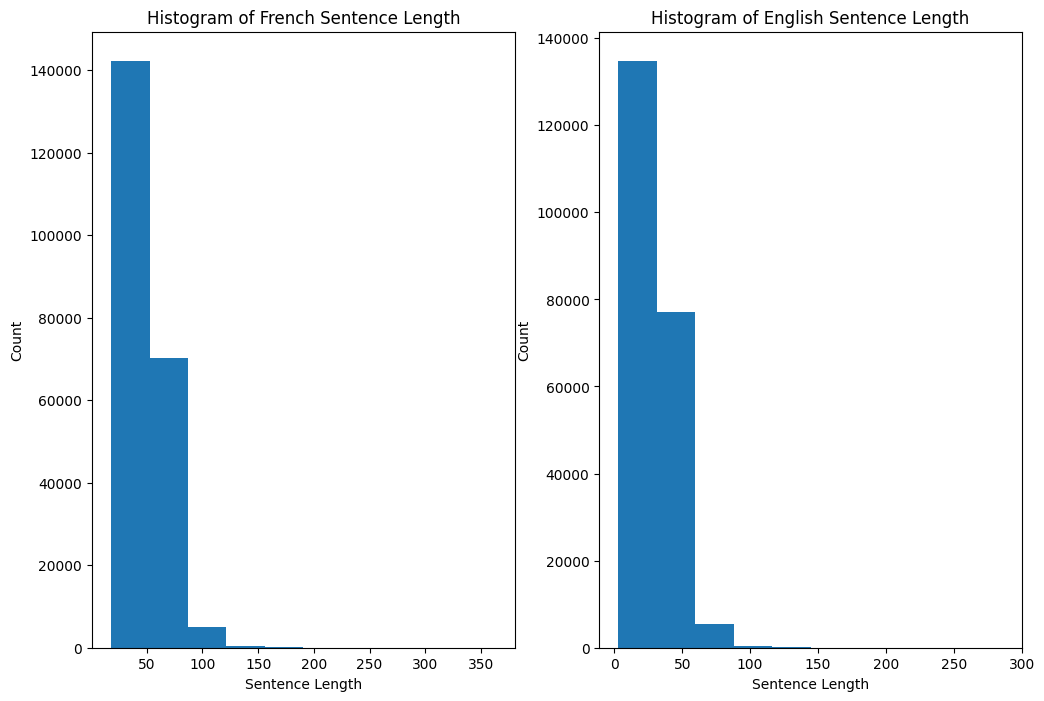

In [ ]:
#Plot the histogram
fig,ax = plt.subplots(1,2,figsize=(12,8))

ax[0].hist(fra_length)
ax[0].set_title("Histogram of French Sentence Length")
ax[0].set_xlabel("Sentence Length")
ax[0].set_ylabel("Count");

ax[1].hist(eng_length)
ax[1].set_title("Histogram of English Sentence Length")
ax[1].set_xlabel("Sentence Length")
ax[1].set_ylabel("Count");

Let's check the distribution of top 1% sentences.

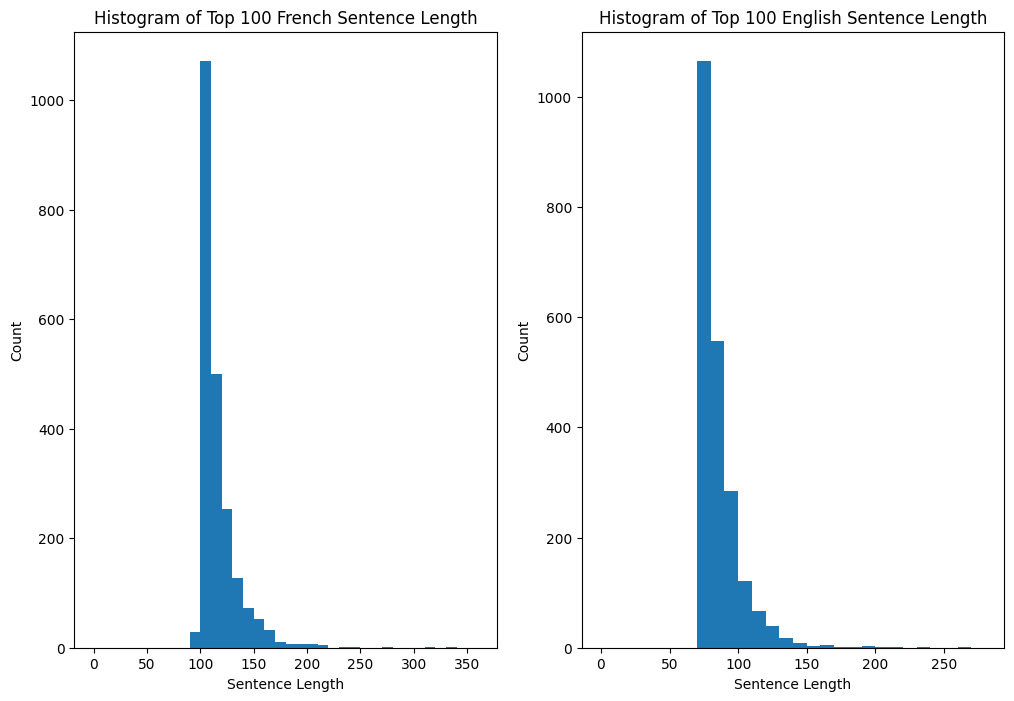

In [ ]:
#Histogram of top 1% longest sentences
one_percent = int(0.01*len(text))
fig,ax = plt.subplots(1,2,figsize=(12,8))
bins = range(0,np.max(fra_length),10)
ax[0].hist(fra_length[-one_percent:],bins=bins)
ax[0].set_title("Histogram of Top 100 French Sentence Length")
ax[0].set_xlabel("Sentence Length")
ax[0].set_ylabel("Count");

bins = range(0,np.max(eng_length),10)
ax[1].hist(eng_length[-one_percent:], bins=bins)
ax[1].set_title("Histogram of Top 100 English Sentence Length")
ax[1].set_xlabel("Sentence Length")
ax[1].set_ylabel("Count");

In [ ]:
print(f"Average sentence length of English sentence is {int(np.mean(fra_length))}")
print(f"Average sentence length of French sentence is {int(np.mean(eng_length))}")

Average sentence length of English sentence is 49
Average sentence length of French sentence is 30


## Vectorization

Our data is in text format. But computers only deal with numbers. So, we'll vectorize the data to convert it to numbers.

We usually discard the punctuation words and special characters to keep the vocabulary small. But since we are building a real-world model, we won't be doin it. We'll keep most of the words as it.

In [ ]:
#Restrict the vocabulary to top 20K words
vocab_size = 20000
#Restrict the sentence length to 80 words
sequence_length = 80

#TextVectorization object for English words
english_vectorization = layers.TextVectorization(
                                    max_tokens=vocab_size,
                                    output_mode="int",
                                    output_sequence_length=sequence_length,
                                               )

#TextVectorization object for French words
french_vectorization = layers.TextVectorization(
                                    max_tokens=vocab_size,
                                    output_mode="int",
                                    #We'll add 1 for offest
                                    output_sequence_length=sequence_length + 1
                                               )

#Get the training sample for English and French sentences
train_english_texts = [sentence[0] for sentence in train_data]
train_french_texts = [sentence[1] for sentence in train_data]

#Learn the vocabulary of English and French language
english_vectorization.adapt(train_english_texts)
french_vectorization.adapt(train_french_texts)

In [ ]:
#Prepare the Tensorflow Dataset Object
batch_size = 64
def format_dataset(eng, fra):
   #Vectorize the text data
   eng = english_vectorization(eng)
   fra = french_vectorization(fra)
   return ({
           "english": eng,
           "french": fra[:, :-1], #Skip the last entry of all the batch
           },
           fra[:, 1:] #Skip the first entry of all the batch
          )
def make_dataset(text_data):
   #Unzip the parsed tupple i.e., (english_sentence, french_sentence)
   eng_texts, fra_texts = zip(*text_data)

   #Convert these to list
   eng_texts = list(eng_texts)
   fra_texts = list(fra_texts)

   #Convert the list data into Tensorflow Dataset Object
   dataset = tf.data.Dataset.from_tensor_slices((eng_texts, fra_texts))
   #Convert the data into Batches
   dataset = dataset.batch(batch_size)

   #Apply the "format_dataset" function on the batched Dataset Object
   dataset = dataset.map(format_dataset, num_parallel_calls=4)

   #Use the prefetch() & cache() methods for efficient resource utilization
   return dataset.shuffle(SEED).prefetch(16).cache()

#Use the above defined functions
train_ds = make_dataset(train_data)
val_ds = make_dataset(val_data)

In [ ]:
#Have a look at the Dataset object shape
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['french'].shape: {inputs['french'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (64, 80)
inputs['french'].shape: (64, 80)
targets.shape: (64, 80)


## Model

In [ ]:
#Define a Transformer Encoder using subclassed layer
class TransformerEncoder(layers.Layer):

   def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
      super().__init__(**kwargs)

      #Size of the input vector (size of the vocabulary)
      self.embed_dim = embed_dim
      #Size of the inner dense layer
      self.dense_dim = dense_dim
      #Number of attention heads
      self.num_heads = num_heads

      self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
      self.dense_proj = keras.Sequential(
                   [layers.Dense(dense_dim, activation="relu"),
                    layers.Dense(embed_dim),]
                                        )
      self.layernorm_1 = layers.LayerNormalization()
      self.layernorm_2 = layers.LayerNormalization()

   #Define a call() method  where forward pass is implemented
   def call(self, inputs, mask=None):
      if mask is not None:
         mask = mask[:, tf.newaxis, :]

      #Apply the attention layer
      attention_output = self.attention(inputs, inputs, attention_mask=mask)
      #Normalize the data
      proj_input = self.layernorm_1(inputs + attention_output)
      #Apply the dense layer
      proj_output = self.dense_proj(proj_input)
      #Normalize the data and return it
      return self.layernorm_2(proj_input + proj_output)

   #Define configuration method
   def get_config(self):
      config = super().get_config()
      config.update({
                    "embed_dim": self.embed_dim,
                    "num_heads": self.num_heads,
                    "dense_dim": self.dense_dim,
                    })
      return config

In [ ]:
# Implementing positional embedding as a subclassed layer
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):

       super().__init__(**kwargs)
       self.sequence_length = sequence_length
       self.input_dim = input_dim
       self.output_dim = output_dim
       self.token_embeddings = layers.Embedding(
          input_dim=input_dim, output_dim=output_dim)
       self.position_embeddings = layers.Embedding(
                   input_dim=sequence_length, output_dim=output_dim)

    def call(self, inputs):
       length = tf.shape(inputs)[-1]
       positions = tf.range(start=0, limit=length, delta=1)
       embedded_tokens = self.token_embeddings(inputs)
       embedded_positions = self.position_embeddings(positions)
       return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
       return tf.math.not_equal(inputs, 0)

    def get_config(self):
       config = super().get_config()
       config.update({
           "output_dim": self.output_dim,
           "sequence_length": self.sequence_length,
           "input_dim": self.input_dim,
                    })
       return config

In [ ]:
#Transformer Decoder
class TransformerDecoder(layers.Layer):
   def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
      super().__init__(**kwargs)

      self.embed_dim = embed_dim
      self.dense_dim = dense_dim
      self.num_heads = num_heads
      self.attention_1 = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_dim)
      self.attention_2 = layers.MultiHeadAttention(
      num_heads=num_heads, key_dim=embed_dim)
      self.dense_proj = keras.Sequential(
          [layers.Dense(dense_dim, activation="relu"),
           layers.Dense(embed_dim),]
                                        )
      self.layernorm_1 = layers.LayerNormalization()
      self.layernorm_2 = layers.LayerNormalization()
      self.layernorm_3 = layers.LayerNormalization()
      self.supports_masking = True
   def get_config(self):
      config = super().get_config()
      config.update({
                   "embed_dim": self.embed_dim,
                   "num_heads": self.num_heads,
                   "dense_dim": self.dense_dim,
                   })
      return config

    #Generates a causal mask
   def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
                   [tf.expand_dims(batch_size, -1),
                   tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    #define the call method()
   def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
             padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
        padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
                    query=inputs,
                    value=inputs,
                    key=inputs,
                    attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
                   query=attention_output_1,
                   value=encoder_outputs,
                   key=encoder_outputs,
                   attention_mask=padding_mask)
        attention_output_2 = self.layernorm_2(
                   attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [ ]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="french")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 english (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 french (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, None, 256)   5140480     ['english[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 positional_embedding_1 (Positi  (None, None, 256)   5140480     ['french[0][0]']             

In [ ]:
#Compile the model
transformer.compile(
                    optimizer="rmsprop",
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"])

In [ ]:
callbacks = [
     keras.callbacks.ModelCheckpoint("eng2french_transformer.keras",
                                      save_best_only=True)
            ]

In [ ]:
#Train the model
transformer.fit(train_ds, epochs=30, validation_data=val_ds,callbacks=callbacks)

Epoch 1/30
2751/2751 [==============================] - 715s 255ms/step - loss: 3.1994 - accuracy: 0.5122 - val_loss: 2.3748 - val_accuracy: 0.6100
Epoch 2/30
2751/2751 [==============================] - 694s 252ms/step - loss: 2.4441 - accuracy: 0.6090 - val_loss: 2.1667 - val_accuracy: 0.6449
Epoch 3/30
2751/2751 [==============================] - 670s 243ms/step - loss: 2.2689 - accuracy: 0.6387 - val_loss: 2.1041 - val_accuracy: 0.6575
Epoch 4/30
2751/2751 [==============================] - 694s 252ms/step - loss: 2.1806 - accuracy: 0.6562 - val_loss: 2.0735 - val_accuracy: 0.6680
Epoch 5/30
2751/2751 [==============================] - 669s 243ms/step - loss: 2.1065 - accuracy: 0.6707 - val_loss: 2.0188 - val_accuracy: 0.6800
Epoch 6/30
2751/2751 [==============================] - 670s 243ms/step - loss: 2.0310 - accuracy: 0.6847 - val_loss: 1.9844 - val_accuracy: 0.6868
Epoch 7/30
2751/2751 [==============================] - 669s 243ms/step - loss: 1.9766 - accuracy: 0.6946 - val_